<a href="https://colab.research.google.com/github/DanteBM/Aprendizaje-Profundo/blob/main/tareas/tarea2/tarea2b_ap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Extiende la libreta 2b comida inception.ipynb para implementar y entrenar la arquitectura tipo ResNet que se especifica en la figura 1. ![figura](figura.png)

# Preparativos

In [ ]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange
# imágenes
from PIL import Image

In [ ]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/e4dZiWt2bZCGWQ9/download'
base_dir = 'datos/recipes'
filename = 'recipes2k.tar.gz'
data_dir = 'recipes/recipes2k'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 64


def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


# reproducibilidad
set_seed()

dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dev # uso de GPU

device(type='cuda', index=0)

In [ ]:
class RecipesDS:

    def __init__(self, root, tsfm):
        
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        
        # leemos el dataframe y filtramos columna healthy
        df = pd.read_csv(os.path.join(root, 'trn.csv'), index_col='item')
        df = df['healthy']
        
        # direcorios superiores
        base_dir = os.path.join(root, 'trn')
        classes = sorted(os.listdir(base_dir))
        
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        
        # por cada clase
        for clazz in classes:
            # directorio de la clase
            class_dir = os.path.join(base_dir, clazz)
            # nombres de los archivos en el directorio de la clase
            names = sorted(os.listdir(class_dir))
            # guardamos los rutas y las etiquetas
            for name in names:
                self.paths.append(os.path.join(class_dir, name))
                self.labels.append(df.loc[clazz])

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

x shape=torch.Size([32, 64, 64, 3]) dtype=torch.uint8
y shape=torch.Size([32, 1]) dtype=torch.float32


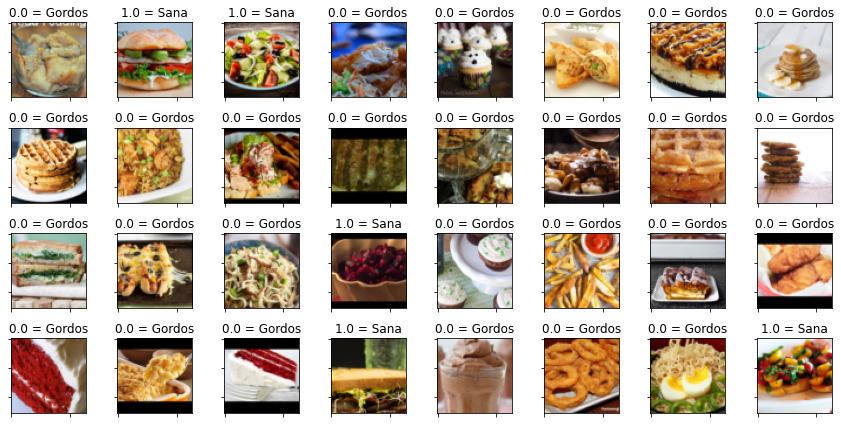

In [ ]:
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # convertimos a ndarray
    np.array
])

ds = RecipesDS(data_dir, tsfm)

dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} = Sana' if l else f'{l.item()} = Gordos' for l in y]
display_grid(x, titles, ROWS, COLS)

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


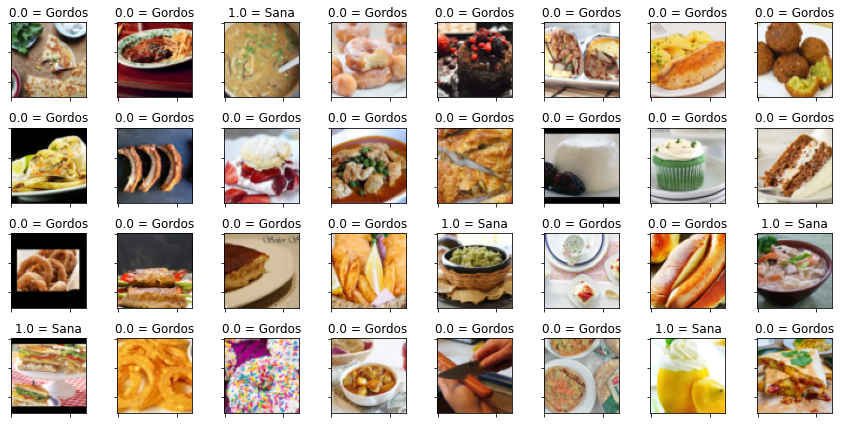

In [ ]:
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor(),
])

trn_ds = RecipesDS(data_dir, tsfm)

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} = Sana' if l else f'{l.item()} = Gordos' for l in y]
display_batch(x, titles, ROWS, COLS)

![figura](figura.png)

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels1, out_channels2):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels1),
            nn.ReLU(),
            
            nn.Conv2d(out_channels1, out_channels2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels2),
            nn.ReLU()
        )
        
        self.conv = nn.Conv2d(in_channels, out_channels2, 
                              kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        y1 = self.seq(x)
        y2 = self.conv(x)
        return y1+y2

In [ ]:
class ResnetModel(nn.Module):
    def __init__(self, in_channels=3, out_channels1=3):
        super().__init__()
        
        out_channels2 = in_channels
        
        self.seq = nn.Sequential(
            ResnetBlock(in_channels, out_channels1, out_channels2),
            nn.MaxPool2d(kernel_size=33, stride=1),
            
            ResnetBlock(in_channels, out_channels1, out_channels2),
            nn.MaxPool2d(kernel_size=17, stride=1),
            
            nn.Flatten(),
            nn.Linear(3*16*16, out_features=1)
        )
        
        
    def forward(self, x):
        y = self.seq(x)
        return y

In [ ]:
model = ResnetModel(in_channels=3, out_channels1=3).to(dev)
model

ResnetModel(
  (seq): Sequential(
    (0): ResnetBlock(
      (seq): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (conv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): MaxPool2d(kernel_size=33, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): ResnetBlock(
      (seq): Sequential(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, t

# Probando modelo

In [ ]:
x = torch.rand(1, 3, 64, 64).to(dev)
y = model(x)
print(y)
print(f'{x.shape} => {y.shape}')

tensor([[-2.2265]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([1, 3, 64, 64]) => torch.Size([1, 1])


In [ ]:
summary(model, (1, 3, 64, 64), device=dev, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 1]                    --
|    └─ResnetBlock: 2-1                  [1, 3, 64, 64]            --
|    |    └─Sequential: 3-1              [1, 3, 64, 64]            180
|    |    └─Conv2d: 3-2                  [1, 3, 64, 64]            12
|    └─MaxPool2d: 2-2                    [1, 3, 32, 32]            --
|    └─ResnetBlock: 2-3                  [1, 3, 32, 32]            --
|    |    └─Sequential: 3-3              [1, 3, 32, 32]            180
|    |    └─Conv2d: 3-4                  [1, 3, 32, 32]            12
|    └─MaxPool2d: 2-4                    [1, 3, 16, 16]            --
|    └─Flatten: 2-5                      [1, 768]                  --
|    └─Linear: 2-6                       [1, 1]                    769
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
Total mult-adds (M): 0.88
Input size (MB): 0.05
Forward/backward pass size (MB): 0.6

# Entrenando

In [ ]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        x, y_true = x.to(dev), y_true.to(dev)
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)
        
        assert not torch.isnan(loss).any(), f"Hay nans :/ {y_lgts, y_true, loss}"
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):
            x, y_true = x.to(dev), y_true.to(dev)

            # computamos los logits
            y_lgts = model(x)
            
            # computamos los puntajes
            y_prob = torch.sigmoid(y_lgts)
            
            # computamos las clases
            y_pred = torch.round(y_prob)

            # computamos la pérdida
            loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, lr=1e-1, epochs=15,
          trn_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)

        # guardamos historial
        loss_hist.append(trn_loss)
        acc_hist.append(trn_acc)

        # imprimimos progreso
        print(f'E{epoch+1:02} loss={trn_loss:6.2f} acc={trn_acc:5.2f}')

    return loss_hist, acc_hist


In [ ]:
loss_hist, acc_hist = train(model, trn_dl, lr=1e-3, epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

E01 loss= 53.59 acc=78.45
E02 loss= 52.69 acc=78.45
E03 loss= 54.26 acc=77.59
E04 loss= 55.00 acc=77.30
E05 loss= 51.28 acc=78.21
E06 loss= 53.08 acc=78.10
E07 loss= 51.46 acc=77.88
E08 loss= 50.01 acc=78.39
E09 loss= 49.55 acc=78.31
E10 loss= 51.51 acc=78.04
E11 loss= 48.70 acc=78.64
E12 loss= 48.28 acc=78.89
E13 loss= 48.52 acc=78.39
E14 loss= 48.33 acc=78.27
E15 loss= 48.47 acc=78.45


# Prueba

In [ ]:
# cargamos imágenes de prueba
imgs = []
tst_dir = os.path.join(data_dir, 'tst')
names = sorted(os.listdir(tst_dir))
for name in names:
    path = os.path.join(tst_dir, name)
    img = io.imread(path)
    size = min(*img.shape[:2])
    img = crop_center(img, size, size)
    img = resize(img, (IMG_SIZE, IMG_SIZE))
    imgs.append(img)

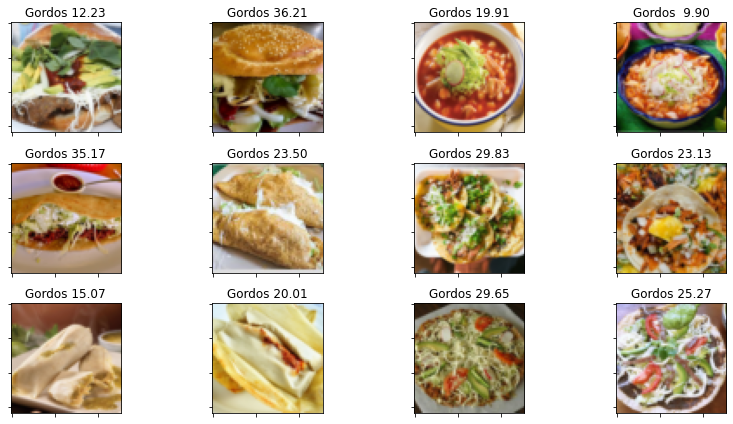

In [ ]:
# desplegamos con probas
titles = []
with torch.no_grad():
    for img in imgs:
        img_torch = numpy_to_torch(img)
        img_torch = img_torch.unsqueeze(0)
        img_torch = img_torch.to(dev)
        prob = torch.sigmoid(model(img_torch))
        prob = prob.item() * 100
        if prob < 50:
            titles.append(f'Gordos {prob:5.2f}%')
        else:
            titles.append(f'Sana {prob:5.2f}%')

display_grid(imgs, titles, 3, 4)